In [1]:
from typing import Tuple, Union, List, Optional
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import json
import mrcfile
import umap
import random

from cryo_sbi.inference.models import build_models
from cryo_sbi import CryoEmSimulator
from cryo_sbi.inference import priors
from cryo_sbi.utils.estimator_utils import sample_posterior, compute_latent_repr
from cryo_sbi.utils.image_utils import (
    LowPassFilter,
    NormalizeIndividual,
    MRCtoTensor,
    mrc_to_tensor,
    FourierDownSample,
    Mask,
    circular_mask,
)
import torchvision.transforms as transforms
from itertools import islice

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from aspire.noise import WhiteNoiseEstimator, AnisotropicNoiseEstimator
from aspire.image import Image
from aspire.source import ArrayImageSource
import mrcfile

from cryo_sbi.utils.image_utils import (
    MRCtoTensor,
)

In [3]:
mrc_to_tensor = MRCtoTensor()
micro_graph_paths = [f"../../6wxb/micro_graphs/micro_graph_0{i}.mrc" for i in range(10)]
# micro_graphs = [mrc_to_tensor(f"{path}") for path in micro_graph_paths]

In [4]:
transform = transforms.Compose(
    [
        MRCtoTensor(),
        FourierDownSample(256, 128),
        NormalizeIndividual(),
    ]
)

In [ ]:
import torch
import torchvision.transforms.functional as TF
import random

random_cutouts = []
transform_patch = transforms.Compose(
    [
        FourierDownSample(256, 128),
    ]
)

patch_size = 256
for i in range(2000):
    idx_m = random.randint(0, 9)
    x = random.randint(patch_size, 4096 - patch_size)
    y = random.randint(patch_size, 4096 - patch_size)
    patch = TF.crop(
        micro_graphs[idx_m], top=y, left=x, height=patch_size, width=patch_size
    )
    patch = transform_patch(patch)
    patch = (patch - patch.mean()) / patch.std()
    random_cutouts.append(patch)
random_cutouts = torch.stack(random_cutouts)

In [140]:
from typing import Optional, Union


class RandomMicrographPatches:
    """
    Iterator that returns random patches from a list of micrographs.

    Args:
        micro_graphs (List[Union[str, torch.Tensor]]): List of micrographs.
        transform (Union[None, transforms.Compose]): Transform to apply to the patches.
        patch_size (int): Size of the patches.
        batch_size (int, optional): Batch size. Defaults to 1.
    """

    def __init__(
        self,
        micro_graphs: List[Union[str, torch.Tensor]],
        transform: Union[None, transforms.Compose],
        patch_size: int,
        max_iter: Optional[int] = 1000,
    ) -> None:
        if all(map(isinstance, micro_graphs, [str] * len(micro_graphs))):
            self._micro_graphs = [mrc_to_tensor(path) for path in micro_graph_paths]
        else:
            self._micro_graphs = micro_graphs

        self._transform = transform
        self._patch_size = patch_size
        self._max_iter = max_iter
        self._current_iter = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self._current_iter == self._max_iter:
            self._current_iter = 0
            raise StopIteration
        random_micrograph = random.choice(self._micro_graphs)
        assert len(random_micrograph.shape) == 2, "Micrograph should be 2D"
        x = random.randint(
            self._patch_size, random_micrograph.shape[0] - self._patch_size
        )
        y = random.randint(
            self._patch_size, random_micrograph.shape[1] - self._patch_size
        )
        patch = TF.crop(
            random_micrograph,
            top=y,
            left=x,
            height=self._patch_size,
            width=self._patch_size,
        )
        if self._transform is not None:
            patch = self._transform(patch)
        self._current_iter += 1
        return patch

    def __len__(self):
        return self._max_iter

    @property
    def shape(self):
        """
        Shape of the transformed patches.

        Returns:
            torch.Size: Shape of the transformed patches.
        """
        return self.__next__().shape


def compute_average_psd(images: Union[torch.Tensor, RandomMicrographPatches]):
    """
    Compute the average PSD of a set of images.

    Args:
        images (Union[torch.Tensor, RandomMicrographPatches]): Images to compute the average PSD of.

    Returns:
        avg_psd (torch.Tensor): Average PSD of the images.
    """

    if isinstance(images, RandomMicrographPatches):
        avg_psd = torch.zeros(images.shape[1:])
        for image in images:
            fft_image = torch.fft.fft2(image[0])
            psd = torch.abs(fft_image) ** 2
            avg_psd += psd / len(images)
    elif isinstance(images, torch.Tensor):
        fft_images = torch.fft.fft2(images, dim=(-2, -1))
        avg_psd = torch.mean(torch.abs(fft_images) ** 2, dim=0)
    return avg_psd

In [136]:
transform = transforms.Compose(
    [
        NormalizeIndividual(),
        FourierDownSample(256, 128),
    ]
)

random_cutouts = RandomMicrographPatches(
    micro_graph_paths, transform=transform, patch_size=256, max_iter=10000
)

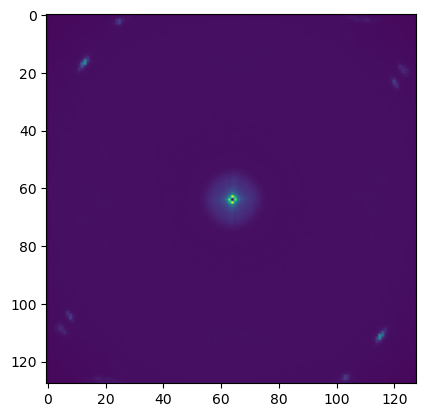

In [139]:
plt.imshow(torch.fft.fftshift(compute_average_psd(random_cutouts)))

1000


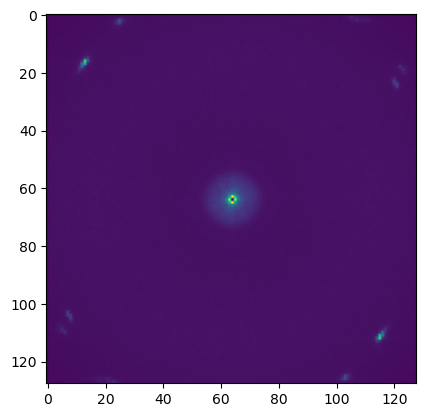

In [132]:
num_images = 1000
random_cutouts = RandomMicrographPatches(
    micro_graph_paths, transform=transform, patch_size=256, max_iter=num_images
)
avg_psd = torch.zeros((128, 128))
i = 0
for patch in random_cutouts:
    i += 1
    fft_image = torch.fft.fft2(patch[0])
    psd = torch.abs(fft_image) ** 2
    avg_psd += psd / num_images
print(i)
plt.imshow(torch.fft.fftshift(avg_psd))

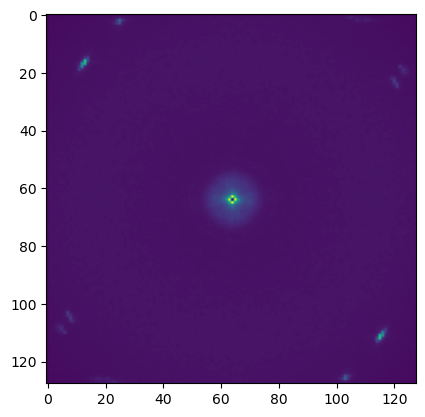

In [130]:
random_cutouts = RandomMicrographPatches(
    micro_graph_paths, transform=transform, patch_size=256, max_iter=num_images
)
images = torch.cat([patch for patch in random_cutouts], dim=0)
plt.imshow(torch.fft.fftshift(compute_average_psd(images)))

In [105]:
raw_images = transform(f"../../6wxb/particles/bio_em_images.mrc")

AttributeError: 'str' object has no attribute 'shape'

In [5]:
# image = ArrayImageSource(random_cutouts.numpy())
image = ArrayImageSource(raw_images.numpy())

2023-05-11 10:19:40,092 INFO Attempting to create an Image object from Numpy array.
2023-05-11 10:19:40,097 INFO Creating ArrayImageSource with 147 images.


In [6]:
noise_estimator = AnisotropicNoiseEstimator(image, bgRadius=1)

2023-05-11 10:19:42,884 INFO Applying forward transformations in pipeline
2023-05-11 10:19:42,884 INFO All forward transformations applied


In [7]:
image.whiten(noise_estimator.filter)

2023-05-11 10:19:46,213 INFO Whitening source object
2023-05-11 10:19:46,214 INFO Transforming all CTF Filters into Multiplicative Filters
2023-05-11 10:19:46,215 INFO Adding Whitening Filter Xform to end of generation pipeline


In [8]:
images = torch.from_numpy(image.images[:].asnumpy())
images = NormalizeIndividual()(images)

2023-05-11 10:19:49,275 INFO Applying forward transformations in pipeline
2023-05-11 10:19:49,276 INFO   Applying FilterXform (PowerFilter)
2023-05-11 10:19:49,321 INFO All forward transformations applied


([], [])

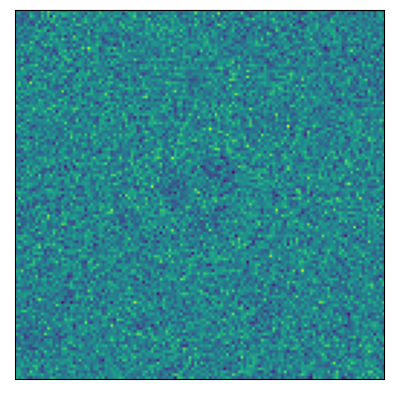

In [9]:
plt.imshow(images[0])
plt.xticks([])
plt.yticks([])
# plt.savefig("whitened_aspire.pdf", dpi=400, bbox_inches="tight")

In [23]:
fft_noise = torch.fft.fft2(random_cutouts, dim=[1, 2])

: 

: 

In [ ]:
noise_psd = torch.abs(fft_noise) ** 2

In [ ]:
noise_psd = noise_psd.mean(dim=0)

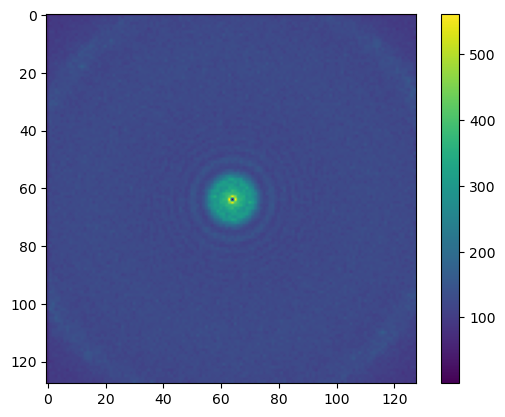

In [ ]:
plt.imshow(torch.fft.fftshift(torch.sqrt(noise_psd)))
plt.colorbar()
plt.savefig("noise_psd.pdf", dpi=400, bbox_inches="tight")

In [14]:
img_fft = torch.fft.fft2(raw_images, dim=[1, 2])
withend = img_fft / torch.sqrt(noise_psd)
raw_withend = torch.fft.ifft2(withend, dim=[1, 2]).real
raw_withend = NormalizeIndividual()(raw_withend)

In [15]:
class WhitenImage:
    def __init__(self, noise_psd):
        self.noise_psd = noise_psd

    def __call__(self, image):
        fft_image = torch.fft.fft2(image)
        fft_image = fft_image / torch.sqrt(self.noise_psd)
        reconstructed = torch.fft.ifft2(fft_image).real
        return reconstructed

([], [])

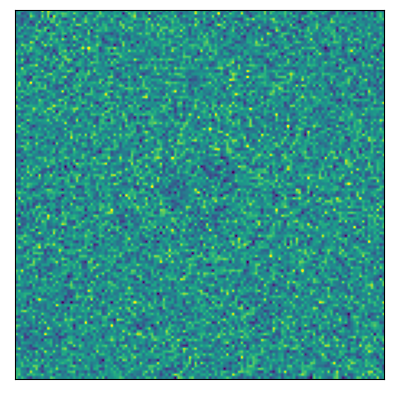

In [16]:
plt.imshow(raw_withend[0], vmax=3, vmin=-3)
plt.xticks([])
plt.yticks([])
# plt.savefig("whitened_psd.pdf", dpi=400, bbox_inches="tight")

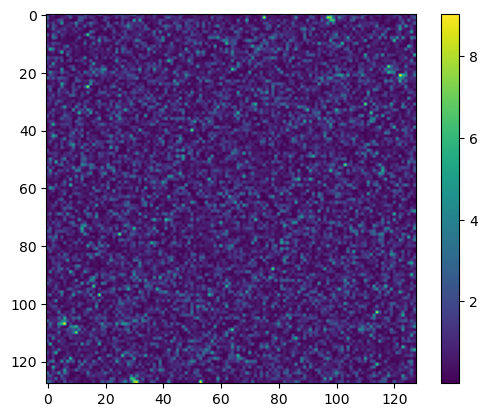

In [17]:
plt.imshow(torch.fft.fftshift(withend[0].abs() ** 2))
plt.colorbar()

In [50]:
whihening_transform = transforms.Compose(
    [
        WhitenImage(noise_psd),
        NormalizeIndividual(),
    ]
)

([], [])

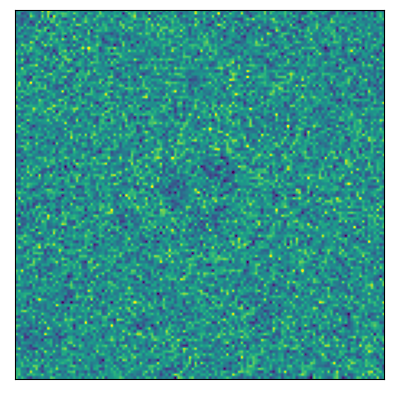

In [52]:
plt.imshow(whihening_transform(raw_images)[0], vmax=3, vmin=-3)
plt.xticks([])
plt.yticks([])
# plt.savefig("raw_image.pdf", dpi=400, bbox_inches="tight")

In [ ]:
plt.imshow(raw_withend[0])
plt.colorbar()

In [ ]:
# compute radiaö average psd of whithened image
fft_white = torch.fft.fft2(raw_withend, dim=[1, 2])
fft_white = torch.abs(fft_white) ** 2
plt.imshow(fft_white[0])

In [ ]:
# normalize image with index 0 to 0 to 1
raw_images[0] -= torch.min(raw_images[0])
raw_images[0] /= torch.max(raw_images[0])

In [ ]:
torch.save(images, "withend_images.pt")

In [ ]:
raw_images = transform(f"../../6wxb/particles/particles_01.mrc")

In [ ]:
plt.imshow(raw_images[0], vmax=1, vmin=0)

In [ ]:
plt.imshow(torch.fft.fftshift(torch.fft.fft2(raw_images[0]).real), vmax=400, vmin=-400)

In [ ]:
plt.imshow(images[0].numpy())

In [ ]:
from aspire.covariance import RotCov2D
from aspire.basis import FFBBasis2D

In [ ]:
ffbbasis = FFBBasis2D((256, 256), dtype=np.float32)

In [ ]:
with mrcfile.open(f"../../6wxb/particles/particles_01.mrc") as f:
    data = f.data
image = ArrayImageSource(data)

In [ ]:
coeff_noise = ffbbasis.evaluate_t(image.images[:].asnumpy())

In [ ]:
covar_opt = {
    "shrinker": "frobenius_norm",
    "verbose": 0,
    "max_iter": 250,
    "iter_callback": [],
    "store_iterates": False,
    "rel_tolerance": 1e-12,
    "precision": "float64",
    "preconditioner": "identity",
}

In [ ]:
cov2d = RotCov2D(ffbbasis)
mean_coeff_est = cov2d.get_mean(coeff_noise)
covar_coeff_est = cov2d.get_covar(
    coeff_noise,
    mean_coeff_est,
)

In [ ]:
covar_coeff_est.dense().shape

In [ ]:
imgs_est = ffbbasis.evaluate(coeff_est)

In [ ]:
transform = transforms.Compose(
    [
        MRCtoTensor(),
        FourierDownSample(256, 128),
        NormalizeIndividual(),
        LowPassFilter(128, 15),
    ]
)

In [ ]:
exp_images = []
for i in range(1, 2):
    if i < 10:
        img_file = f"../../6wxb/particles/particles_0{i}.mrc"
    else:
        img_file = f"../../6wxb/particles/particles_{i}.mrc"
    tmp_images = transform(img_file)
    exp_images.append(tmp_images)
exp_images = torch.cat(exp_images, dim=0)

In [ ]:
exp_images.shape

In [ ]:
test_images = exp_images.reshape(128**2, -1).cuda()

In [ ]:
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    print("Computing ZCA whitening matrix (aka Mahalanobis whitening)...")
    print("Computing covariance matrix...")
    sigma = torch.cov(X)  # [M x M]

    # Singular Value Decomposition. X = U * np.diag(S) * V
    print("Computing SVD...")
    U, S, V = torch.linalg.svd(sigma)
    # U: [M x M] eigenvectors of sigma.
    # S: [M x 1] eigenvalues of sigma.
    # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    print("Computing ZCA matrix...")
    ZCAMatrix = torch.matmul(
        U, torch.matmul(torch.diag(1.0 / torch.sqrt(S + epsilon)), U.T)
    )  # [M x M]
    print("Finished computing ZCA whitening matrix.")
    return ZCAMatrix

In [ ]:
zca_matrix = zca_whitening_matrix(test_images)

In [ ]:
test_images.mean(dim=0).shape

In [ ]:
a = transforms.LinearTransformation(zca_matrix, test_images.mean(dim=1))

In [ ]:
w_image = torch.matmul(zca_matrix, test_images[:, 1].reshape(-1, 1))

In [ ]:
plt.imshow(w_image.reshape(128, 128).cpu().numpy())

In [ ]:
plt.imshow(a(test_images[:, 0].reshape(-1, 1)).cpu().reshape(128, 128))

In [ ]:
# Plot one image from exp_images
plt.imshow(
    exp_images[1].reshape(128, 128).cpu().numpy(), cmap="binary", vmin=-4, vmax=4
)
plt.show()

In [ ]:
X = exp_images[:3].reshape(128 * 128, 3).cpu().numpy()

In [ ]:
cov.shape

In [ ]:
zca.shape

In [ ]:
X[0]

In [ ]:
zca[0]

In [ ]:
zca = zca.reshape(3, 128, 128)

In [ ]:
plt.imshow(zca[1], cmap="binary", vmin=-4, vmax=4)

In [ ]:
import torch.distributions as dist

In [ ]:
transform = transforms.Compose(
    [
        MRCtoTensor(),
        FourierDownSample(256, 128),
        NormalizeIndividual(),
        # Mask(128, 32, inside=True),
    ]
)

In [ ]:
cov_var = torch.cov(exp_images.reshape(128**2, -1), correction=0)

In [ ]:
import torch

In [ ]:
cov_var = torch.eye(128**2)
cov_var[100, 1] = cov_var[1, 100] = 1
cov_var[100, 100] = 2

In [ ]:
mvg = dist.MultivariateNormal(torch.zeros(128**2), cov_var)

In [ ]:
test_samples = mvg.sample((10000,))

In [ ]:
import torch
from torch.distributions import MultivariateNormal
import torch.optim as optim
import matplotlib.pyplot as plt

dim = 3


mean_true = torch.zeros(dim, device="cuda")
cov_true = torch.tensor(
    [[1.0, 0.9, 0.1], [0.9, 2.0, 0.0], [0.1, 0.0, 1.0]], device="cuda:0"
)

mvn_true = MultivariateNormal(mean_true, cov_true)

train_samples = mvn_true.sample((1000,))
val_samples = mvn_true.sample((1000,))

In [ ]:
mean = torch.zeros(dim, device="cuda")
cov = torch.eye(dim, requires_grad=True, device="cuda")


optimizer = optim.SGD([cov], lr=0.001, momentum=0.01, weight_decay=0)

mvn = MultivariateNormal(
    loc=mean,
    scale_tril=cov,
)

train_losses = []
val_losses = []

for i in range(10000):
    optimizer.zero_grad()
    loss = -mvn.log_prob(train_samples.cuda()).mean()
    loss.backward()
    optimizer.step()

# plt.plot(train_losses, label="train")
# plt.plot(val_losses,  label="val")
# plt.legend()
print(cov_true)
print()
print(cov)
print()
print(torch.linalg.cholesky(torch.cov(train_samples.cuda().T)))

In [ ]:
mvn.log_prob(train_samples[0].cuda()).mean()

In [ ]:
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [
        MRCtoTensor(),
        FourierDownSample(256, 128),
        NormalizeIndividual(),
        # Mask(128, 32, inside=True),
    ]
)

In [ ]:
exp_images = []
for i in range(1, 70):
    if i < 10:
        img_file = f"../../6wxb/particles/particles_0{i}.mrc"
    else:
        img_file = f"../../6wxb/particles/particles_{i}.mrc"
    tmp_images = transform(img_file)
    exp_images.append(tmp_images)
exp_images = torch.cat(exp_images, dim=0)

In [ ]:
test_images = transform("../../6wxb/particles/particles_66.mrc")

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.imshow(test_images[idx + 40], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_xticks([])

In [ ]:
mrc_to_tensor = MRCtoTensor()
micro_graph_paths = [f"../../6wxb/micro_graphs/micro_graph_0{i}.mrc" for i in range(10)]
micro_graphs = [mrc_to_tensor(f"{path}") for path in micro_graph_paths]

In [ ]:
import torch
import torchvision.transforms.functional as TF
import random

random_cutouts = []
transform_patch = transforms.Compose(
    [
        FourierDownSample(256, 128),
    ]
)

patch_size = 256
for i in range(200000):
    idx_m = random.randint(0, 9)
    x = random.randint(patch_size, 4096 - patch_size)
    y = random.randint(patch_size, 4096 - patch_size)
    patch = TF.crop(
        micro_graphs[idx_m], top=y, left=x, height=patch_size, width=patch_size
    )
    patch = transform_patch(patch)
    patch = (patch - patch.mean()) / patch.std()
    random_cutouts.append(patch)
random_cutouts = torch.stack(random_cutouts)

In [ ]:
plt.imshow(random_cutouts[10], vmax=4, vmin=-4)

In [ ]:
import torch
from torch.distributions import MultivariateNormal
import torch.optim as optim

mean = torch.zeros(128**2, device="cuda")
cov = torch.eye(128**2, requires_grad=True, device="cuda")

# optimizer = optim.SGD([cov],  lr=0.01, weight_decay=0.1, momentum=0.1)
optimizer = optim.Adagrad([cov], lr=0.001)

mvn = MultivariateNormal(loc=mean, scale_tril=cov)

train_losses = []
val_losses = []

for i in range(500):
    optimizer.zero_grad()
    batch_idx = torch.randperm(random_cutouts.shape[0])[:5000]
    loss = -mvn.log_prob(random_cutouts.reshape(-1, 128**2)[batch_idx].cuda()).mean()
    loss.backward()
    optimizer.step()
    # plt.imshow(mvn.sample().reshape((128, 128)).cpu(), cmap="binary", vmin=-4, vmax=4)
    # val_loss = -mvn.log_prob(test_images.cuda().reshape(-1, 128**2)).cuda().mean()
    train_losses.append(loss.item())
    # val_losses.append(val_loss.item())
    if i % 50 == 0:
        print("Loss :", loss.item(), end="\n")
        # sample = mvn.sample().reshape((128, 128)).cpu()
        # sample /= sample.std()
        # plt.imshow(sample, cmap="binary", vmin=-4, vmax=4)
        # plt.show()

In [ ]:
plt.imshow(mvn.sample().reshape((128, 128)).cpu(), cmap="binary")

In [ ]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("Optimization steps")
plt.ylabel("Negative log likelihood")
plt.legend()

In [ ]:
# torch.save(cov.detach().cpu(),'cov_2.pt')

In [ ]:
plt.imshow(test_images[0], cmap="binary", vmin=-4, vmax=4)

In [ ]:
norm = NormalizeIndividual()

In [ ]:
plt.imshow(images[3], cmap="binary", vmin=-4, vmax=4)

In [ ]:
images = torch.load("6wxb_examples.pt")

In [ ]:
new_images = 1 * images + 5 * norm(
    mvn.sample((images.shape[0],)).reshape((-1, 128, 128)).cpu()
)
new_images = norm(new_images)

In [ ]:
img_file = "../../6wxb/particles/bio_em_images.mrc"
comp_images = transform(img_file)

In [ ]:
lpf = LowPassFilter(128, 15)

In [ ]:
# idx_images = torch.tensor([4, 3, 10, 2])
idx_images = torch.tensor([10, 15, 38, 0])
fig, axes = plt.subplots(2, 4, figsize=(15, 9), sharex=True)


# for i, ax in enumerate(axes[1]):
#    ax.imshow(bioEM_images[i], vmax=4, vmin=-4, cmap="binary")
#    ax.set_yticks([])
#    ax.set_yticks([])

# test_images = norm(test_images)
for i, ax in enumerate(axes[0]):
    ax.imshow(comp_images[idx_images[i]], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_yticks([])
    ax.set_xticks([])


for i, ax in enumerate(axes[1]):
    ax.imshow(new_images[i], vmax=4, vmin=-4, cmap="binary")
    ax.set_yticks([])
    ax.set_yticks([])

In [ ]:
# idx_images = torch.tensor([4, 3, 10, 2])
idx_images = torch.tensor([10, 15, 38, 0])
max_min = (0, 13)
fig, axes = plt.subplots(2, 4, figsize=(15, 9), sharex=True)

fft_sim = torch.fft.fftshift(torch.fft.fft2(new_images[i])).abs().pow(2).log()
for i, ax in enumerate(axes[1]):
    ax.imshow(fft_sim, vmax=max_min[1], vmin=max_min[0])
    ax.set_yticks([])
    ax.set_yticks([])

# for i, ax in enumerate(axes[1]):
#    ax.imshow(bioEM_images[i], vmax=4, vmin=-4, cmap="binary")
#    ax.set_yticks([])
#    ax.set_yticks([])

fft_exp_images = (
    torch.fft.fftshift(torch.fft.fft2(comp_images, dim=(-2, -1))).abs().pow(2).log()
)
for i, ax in enumerate(axes[0]):
    ax.imshow(fft_exp_images[idx_images[i]], vmax=max_min[1], vmin=max_min[0])
    ax.set_yticks([])
    ax.set_xticks([])

In [ ]:
from torch.distributions import MultivariateNormal
import torch

In [ ]:
mean = torch.zeros(128**2, device="cpu")
cov = torch.eye(128**2, device="cpu")
torch.set_num_threads(1)

mvn = MultivariateNormal(loc=mean, scale_tril=cov)

In [ ]:
import numpy as np

In [ ]:
mean_np = np.zeros(128**2)
cov_np = np.eye(128**2)

In [ ]:
rng = np.random.default_rng()

In [ ]:
%timeit rng.multivariate_normal(mean_np, cov_np, method="cholesky")

In [ ]:
plt.imshow(exp_images[0].cpu())

In [ ]:
image_transform_test = exp_images[0]

In [ ]:
t = (
    torch.matmul(cov**-1, image_transform_test.reshape(128**2).cuda())
    .reshape((128, 128))
    .cpu()
)

In [ ]:
plt.imshow(t.detach().numpy())

In [ ]:
import numpy as np

In [ ]:
np.random.uniform(-1, 1, size=(2,))

In [ ]:
coords = np.load("../data/protein_models/")